In [1]:
from __future__ import annotations

__all__ = ['CircuitAnsatz',
           'IQPAnsatz',
           'Sim4Ansatz',
           'Sim14Ansatz',
           'Sim15Ansatz',
           'StronglyEntanglingAnsatz']

from abc import abstractmethod
from collections.abc import Callable, Mapping
from itertools import cycle
from typing import Type

import numpy as np
from sympy import Symbol, symbols

from lambeq.ansatz import BaseAnsatz
from lambeq.backend.grammar import Box, Diagram, Functor, Ty
from lambeq.backend.quantum import (
    Bra,
    CRz,
    Diagram as Circuit,
    Discard,
    H,
    CX,
    Id,
    Ket,
    quantum,
    qubit,
    Rotation,
    Rx, Ry, Rz
)

from lambeq import AtomicType

'''
We want to understand the DisCoPy side of Lambeq to write an entangling circuit 
'''

/home/bob/anaconda3/envs/code/lib/python3.9/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


'\nWe want to understand the DisCoPy side of Lambeq to write an entangling circuit \n'

In [2]:

# circuit = Ket(0) @ Ket(0)



circuit = H @ qubit @ Id(3) >> CX @ Id(3) >> Discard() @ Id(4) 
dom, cod = circuit.dom, circuit.cod


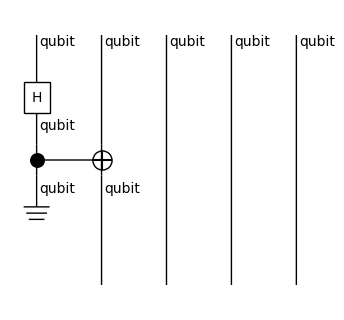

In [3]:
print(dom, cod)


circuit.draw(figsize = (3,3))


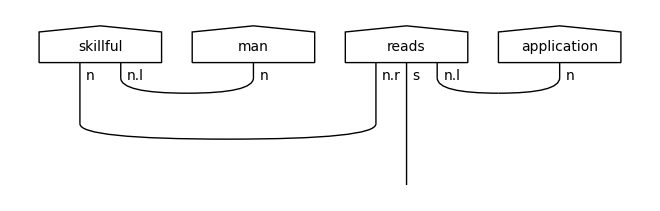

In [4]:

# from IQPAmplitudeEncodeDM import IQPDensityMatrix

test_data = 'skillful man reads application'


from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_test_diagrams = parser.sentence2diagram(test_data, suppress_exceptions=True)

raw_test_diagrams.draw()

# from lambeq import RemoveCupsRewriter

# remove_cups = RemoveCupsRewriter()

# # train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
# # dev_diagrams = [remove_cups(diagram) for diagram in raw_val_diagrams]
# # test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]
# test_diagram = remove_cups(raw_test_diagrams)



# ansatzDM = IQPDensityMatrix({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
#                    n_layers=1, nounParams = np.array([1,1]), n_single_qubit_params=3)



# test_circuit = IQPDensityMatrix({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1}, n_layers=1, nounParams=np.array([0,1]))(test_diagram)

# print(test_circuit)

# test_circuit.draw(figsize = (3,3), output = 'mpl')

In [5]:
interestingPart = test_circuit[13]

print(interestingPart)

a = interestingPart.boxes
print(a)
print(type(a))
a.insert(1,0)
print(a)


tKetCirc = test_circuit.to_tk()



NameError: name 'test_circuit' is not defined

In [ ]:
from pytket.extensions.qiskit import tk_to_qiskit

qiskit_circuit = tk_to_qiskit(tKetCirc)

# qiskit_circuit.draw()

# print(qiskit_circuit[0])

# qiskit_circuit.parameters

# if 'woman†_n__0' in str(qiskit_circuit.parameters) or 'man†_n__0' in str(qiskit_circuit.parameters): 
#     # just delete the gates alltogether and the measurement 
# else: 
    


In [ ]:
from qiskit.circuit import Parameter

# dinner__n_0 = Parameter('dinner__n_0')

params = qiskit_circuit.parameters

print(params)

# print(params[0])

# set new parameters, this is how we create the circuit in Qiskit!! 
qiskit_circuit = qiskit_circuit.assign_parameters({params[0]: 5})

# qiskit_circuit.draw()

test = qiskit_circuit.data

# print(type(test))

# print(type(test[1]))

print('test ', (str(test[1].operation.params)))

indexList = []

for i in range(len(test)): 
    if 'man' in str(test[i].operation.params):
        indexList.append(i)
        print(str(test[i].operation.params))

        
print(indexList)

qiskit_circuit.data.pop(indexList[0])
qiskit_circuit.data.pop(indexList[1]-1)
qiskit_circuit.data.pop(indexList[2]-2)
# qiskit_circuit.draw()

# qiskit_circuit.data[4]

# len(qiskit_circuit.data)

# for i in range(22): 
#     print(qiskit_circuit.data[i])

ParameterView([Parameter(dinner†_n__0), Parameter(dinner†_n__1), Parameter(dinner†_n__2), Parameter(man__n_0), Parameter(man__n_1), Parameter(man__n_2), Parameter(prepares__n.r@s@n.l_0), Parameter(prepares__n.r@s@n.l_1), Parameter(skillful†_n@n.l__0)])
test  []
[ParameterExpression(2*pi*man__n_0)]
[ParameterExpression(2*pi*man__n_1)]
[ParameterExpression(2*pi*man__n_2)]
[0, 4, 6]


CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[ParameterExpression(2*pi*man__n_2)]), qubits=(Qubit(QuantumRegister(4, 'q'), 0),), clbits=())

In [6]:
'''
Function to go through the test diagrams one by one 
and modify them accordingly. 
'''
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.converters import dag_to_circuit, circuit_to_dag

def SetUpDiags(circuit: QuantumCircuit, parameterDict: dict, WordsToForget: list = ['man', 'woman', 'person']):
    '''
    Given a circuit as an Input, we remove the noun parameters belonging to the first noun in the sentence. 

    We then, depending on the shape of the circuit, replace the noun parameters by an entangled Bell state or we forget about it. 

    In the end, we replace the verb parameters by the parameters learned by the model. 

    The reason we are doing this is to introduce a model with real uncertainty. 

    wordsToForget: list of strings of words that we want to forget ('man', 'woman', 'person', ...)

    '''
    # remove noun parameters and set the rest of the parameters 

    # start by extracting circuit data 
    circuitData = circuit.data


    # list to store the nounParameters to be removed 
    indexList = []

    # boolean that tells us if the noun of interest is daggered or not 
    dagger = False 

    for i in range(len(circuitData)): 

        # check if this gate has a parameter of a word we want to forget about
        for word in WordsToForget:
            if word in str(circuitData[i].operation.params):

                # store the parameter in a list
                indexList.append(i)

                qubitOfInterest = circuitData[i].qubits[0].index

                if '†' in str(circuitData[i].operation.params):
                    dagger = True 
                    


    # FIRST: UPDATE THE PARAMETERS, THEN REMOVE THE GATES FROM THE CIRCUIT 

    # get parameters of the remaining circuit 
    params = circuit.parameters


    # set the parameters of the remaining words based on the models weights 
    for i in range(len(params)):
        # print(str(params[i]))
        # print(parameterDict[str(params[i])])
        if str(params[i]) in parameterDict:
            circuit = circuit.assign_parameters({params[i]: parameterDict[str(params[i])]})
        else: 
            # if the model only learned parameters for the word that are not daggered
            if '†' in str(params[i]):
               tempParam = str(params[i])
               # reverse string 
               tempParam = tempParam[::-1]

               # remove elements 2,3,4,5
               tempParam = tempParam[:2] + 'n__' + tempParam[5:]

               tempParam = tempParam[::-1]
               print(tempParam)             

               circuit = circuit.assign_parameters({params[i]: parameterDict[tempParam]}) 

        
    

    # remove the parameters of the words we want to forget
    circuit.data.pop(indexList[0])
    circuit.data.pop(indexList[1]-1)
    circuit.data.pop(indexList[2]-2)



    # if the word we want to forget about is an effect, we simply forget about the qubit 
    if dagger: 
        # remove measurement 
        circuitData = circuit.data

        for i in range(len(circuitData)):

            if str(circuitData[i].operation.name) == 'measure': 
                if circuitData[i].qubits[0].index == qubitOfInterest: 
                    circuit.data.pop(i)
                    break
        
        # that's it 
        

    # if the word we want to forget about is a state, we introduce a bell state and clip it to the beginning of the circuit 
    if not dagger: 
        # introduce circuit with 5 qubits to be composed with the initial circuit 
        bellCircuit = QuantumCircuit(5)
        # bell state on first two qubits 
        bellCircuit.h(0)

        # entangle the artificial qubit with the qubit of interest
        bellCircuit.cx(0,qubitOfInterest + 1)

        # now, add one 'artificial' qubit to the initial circuit 
        q = QuantumRegister(1, 'q')
        circuit = circuit.reverse_bits()
        circuit.add_bits(q)
        circuit = circuit.reverse_bits()

        # now that the two circuits are equal in length, combine them 
        circuit = bellCircuit.compose(circuit, qubits=[0,1,2,3,4])

        # now, we have our circuit 

    circuit.draw(output= 'mpl', filename='testtest.png')


    return circuit, not dagger


from lambeq import BobcatParser
from lambeq import RemoveCupsRewriter
from lambeq import IQPAnsatz

from pytket.extensions.qiskit import tk_to_qiskit






In [7]:

'''
Now, for the density matrices 
'''
from qiskit import QuantumCircuit
from qiskit.quantum_info import DensityMatrix, partial_trace
from qiskit.visualization import plot_state_city



def GetDensityMatrix(circuit: QuantumCircuit, traceList: list, addedQubit: bool):
    '''
    Given a QuantumCircuit representing a sentence, this function returns the density matrix of the *sentence* qubit 
    ''' 
    import qiskit.quantum_info as qi 
    from qiskit.providers.aer import AerSimulator
    
    dmSimulation = AerSimulator()

    job = dmSimulation.run(circuit.decompose(reps = 1))



    result = job.result()

    # print(result)

    data = result.data()

    rho = data.get('density_matrix')

    # print('CIRCUIT IN DENSITY MATRIX')
    # print(circuit)

    # differentiate between dagger and not dagger (one has one qubit less)
    # dagger
    # if circuit.num_qubits == 4: 
    #     sentenceDM = partial_trace(state=rho, qargs=[0, 2, 3])

    # # not dagger 
    # elif circuit.num_qubits == 5: 
    #     sentenceDM = partial_trace(state=rho, qargs=[0, 1, 2, 4])

    # # simple sentence like man prepares food, without any adjectives, man will be daggered there 
    # elif circuit.num_qubits == 3: 
    #     sentenceDM = partial_trace(state=rho, qargs=[0,2])

    if not addedQubit:
        sentenceDM = partial_trace(state=rho, qargs= traceList)
    if addedQubit: 
        traceList = [i+1 for i in traceList]
        traceList.insert(0,0)
        # print('modified tracelist if appended:', traceList)
        sentenceDM = partial_trace(state=rho, qargs= traceList)

    # else: 
    #     print('number of qubits: ', circuit.num_qubits)
    #     print(circuit)

    return sentenceDM
    
# test = GetDensityMatrix(circuitOfInterest)

# print(circuitOfInterest)
# plot_state_city(test)


In [15]:
'''
now for the application of the code
'''

def Main(listOfCircuits: list, parameterDict: dict, wordsToForget: list):
    '''
    Iterate over all circuits in the test_circuits list and for each of them create the density matrix as explained above 
    ''' 

    listOfDensityMatrices: list = []


    from pytket.extensions.qiskit import tk_to_qiskit

    numQubitsList: list = []

    for i in range(len(listOfCircuits)): 

        print('iteration number: ', i)

        tempCirc = listOfCircuits[i]

        # if i == 8: 
        #     tempCirc.draw()

        tempCircTK = tempCirc.to_tk()

        tempCircQiskit = tk_to_qiskit(tempCircTK)

        # if i == 8: 
        #     print(tempCircQiskit)

        circuitData = tempCircQiskit.data

        # list of qubits that shall be forgotten when traced over
        traceList = []
        for i in range(len(circuitData)):
            if str(circuitData[i].operation.name) == 'measure':
                traceList.append(circuitData[i].qubits[0].index)
        # print('traceList: ', traceList)

        alteredTempCirc, addedQubit = SetUpDiags(tempCircQiskit, parameterDict, wordsToForget)

        # to access density matrix later on 
        alteredTempCirc.save_density_matrix() 

        densityMatrix = GetDensityMatrix(alteredTempCirc, traceList, addedQubit) 
        
        listOfDensityMatrices.append(densityMatrix)

        numQubitsList.append(tempCircQiskit.num_qubits)

    return listOfDensityMatrices, numQubitsList
    



# one of these two is wordsToForget
wordsToForgetSubj = ['man', 'woman', 'person']
wordsToForgetObj  = ['dinner', 'meal', 'sauce', 'program', 'application', 'software']

# load dictionary with pickle
import pickle 

# Numpymodel 
with open('weightsDictNP.pkl', 'rb') as fp: 
    parameterDictNP = pickle.load(fp)

# Pennylane model 
with open('weightsDictPL.pkl', 'rb') as fp: 
    parameterDictPL = pickle.load(fp)

# TKet model 
with open('weightsDictTK.pkl', 'rb') as fp: 
    parameterDictTK = pickle.load(fp)




In [10]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


test_labels, test_data = read_data('../datasets/mc_test_data.txt')

# new way, maybe the things after the words confused lambeq in creating the diagrams 
with open('../datasets/newTestSentences.txt', 'r') as file: 
    test_data = file.readlines()

test_data = [sentence.strip() for sentence in test_data]



from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)

from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

# this is the list of circuits that we will input in the model 
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [16]:
'''
We can create a number of different density matrices with our setup. 
'''

# Numpy model
dmListNPSubj, nQNPS = Main(listOfCircuits= test_circuits, parameterDict= parameterDictNP, wordsToForget= wordsToForgetSubj)
dmListNPObj, nQNPO  = Main(listOfCircuits= test_circuits, parameterDict= parameterDictNP, wordsToForget= wordsToForgetObj)

# Pennylane model 
dmListPLSubj, nQPLS = Main(listOfCircuits= test_circuits, parameterDict= parameterDictPL, wordsToForget= wordsToForgetSubj)
dmListPLObj, nQPLO  = Main(listOfCircuits= test_circuits, parameterDict= parameterDictPL, wordsToForget= wordsToForgetObj)

# Tket model
dmListTKSubj, nQTKS  = Main(listOfCircuits= test_circuits, parameterDict= parameterDictTK, wordsToForget= wordsToForgetSubj)
dmListTKObj, nQTKO  = Main(listOfCircuits= test_circuits, parameterDict= parameterDictTK, wordsToForget= wordsToForgetObj)

iteration number:  0


/tmp/ipykernel_18523/3093554144.py:39: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  traceList.append(circuitData[i].qubits[0].index)
/tmp/ipykernel_18523/1272278593.py:43: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  qubitOfInterest = circuitData[i].qubits[0].index
/tmp/ipykernel_18523/1272278593.py:95: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of

iteration number:  1
iteration number:  2
iteration number:  3
iteration number:  4
iteration number:  5
iteration number:  6
iteration number:  7
iteration number:  8
iteration number:  9
iteration number:  10
iteration number:  11
iteration number:  12
iteration number:  13
iteration number:  14
iteration number:  15
iteration number:  16
iteration number:  17
iteration number:  18
iteration number:  19
iteration number:  20
iteration number:  21
iteration number:  22
iteration number:  23
iteration number:  24
iteration number:  25
iteration number:  26
iteration number:  27
iteration number:  28
iteration number:  29
iteration number:  0
iteration number:  1
iteration number:  2
iteration number:  3
iteration number:  4
iteration number:  5
iteration number:  6
iteration number:  7
iteration number:  8
iteration number:  9
iteration number:  10
iteration number:  11
iteration number:  12
iteration number:  13
iteration number:  14
iteration number:  15
iteration number:  16
iterati

In [27]:
from qiskit.quantum_info import entropy

# s = entropy(dmOne)

# four entropy lists 
# entropyNPSubj: list = []
# entropyNPObj: list = []
# entropyPLSubj: list = []
# entropyPLObj: list = []
# entropyTKSubj: list = []
# entropyTKObj: list = []

# for i in range(len(dmListNPSubj)):
    # entropyNPSubj.append(entropy(dmListNPSubj[i]))
    # entropyNPObj.append(entropy(dmListNPObj[i]))
    # entropyPLSubj.append(entropy(dmListPLSubj[i]))
    # entropyPLObj.append(entropy(dmListPLObj[i]))
#     entropyTKSubj.append(entropy(dmListTKSubj[i]))
#     entropyTKObj.append(entropy(dmListTKObj[i]))

def getEntropyByQubit(dmList, nQList):
    e3 = []
    e4 = []
    e5 = []
    for i in range(len(dmList)):
        if nQList[i] == 3: 
            e3.append(entropy(dmList[i]))
        if nQList[i] == 4: 
            e4.append(entropy(dmList[i]))
        if nQList[i] == 5: 
            e5.append(entropy(dmList[i]))
    
    listOfLists = [e3,e4,e5]

    entropies = np.zeros(3)

    for i in range(len(listOfLists)): 
        tempList = listOfLists[i]
        if len(tempList) != 0: 
            entropies[i] = sum(tempList)/len(tempList)
        else: 
            continue
            

    return entropies


eNPS = getEntropyByQubit(dmListNPSubj, nQNPS)
eNPO = getEntropyByQubit(dmListNPObj, nQNPO)
ePLS = getEntropyByQubit(dmListPLSubj, nQPLS)
ePLO = getEntropyByQubit(dmListPLObj, nQPLO)
eTKS = getEntropyByQubit(dmListTKSubj, nQTKS) 
eTKO = getEntropyByQubit(dmListTKObj, nQTKO)



print('Numpy, forget subject, entropy by Qubit: ', eNPS)
print('Numpy, forget object, entropy by Qubit: ', eNPO)
print('Pennylane, forget subject, entropy by Qubit: ', ePLS)
print('Pennylane, forget object, entropy by Qubit: ', ePLO)
print('Tket, forget subject, entropy by Qubit: ', eTKS)
print('Tket, forget object, entropy by Qubit: ', eTKO)




Numpy, forget subject, entropy by Qubit:  [0.72323531 0.55995473 0.        ]
Numpy, forget object, entropy by Qubit:  [0.79544187 0.63191291 0.        ]
Pennylane, forget subject, entropy by Qubit:  [0.1556474  0.22691668 0.        ]
Pennylane, forget object, entropy by Qubit:  [0.19464892 0.25490133 0.        ]
Tket, forget subject, entropy by Qubit:  [0.64642094 0.71346927 0.        ]
Tket, forget object, entropy by Qubit:  [0.71685529 0.74199354 0.        ]


In [14]:
import matplotlib.pyplot as plt 

netNPSubj = sum(entropyNPSubj)
netNPObj = sum(entropyNPObj)
netPLSubj = sum(entropyPLSubj)
netPLObj = sum(entropyPLObj)
netTKSubj = sum(entropyTKSubj)
netTKObj = sum(entropyTKObj)

print(netNPSubj, netNPObj, netPLSubj, netPLObj, netTKSubj, netTKObj)


# plt.plot(entropyNPSubj)
# plt.show()

# plt.plot(entropyNPObj)
# plt.show()

# plt.plot(entropyPLSubj)
# plt.show()

# plt.plot(entropyPLObj)
# plt.show()




18.767522213787178 20.960562786218617 5.988063523791828 6.933342246584085 20.60685361263221 22.027019333248305
